# Submission using XGBoost

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

## Prepare data

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_pickle('input/train.p')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 9 columns):
is_duplicate     404290 non-null int64
question1        404290 non-null object
question2        404290 non-null object
diff_avg_word    404290 non-null float64
tf_distance1     404290 non-null float64
tf_distance2     404290 non-null float64
cnt_distance     404290 non-null float64
jaccard_dist     404290 non-null float64
word_match       404290 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 30.8+ MB


In [7]:
training_fields = ['diff_avg_word', 'tf_distance1', 'tf_distance2', 'cnt_distance', 'jaccard_dist', 'word_match']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
        df[training_fields], df['is_duplicate'], test_size=0.2, random_state=42)

## Training XGBoost model

In [9]:
import xgboost as xgb

In [10]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

In [11]:
d_train = xgb.DMatrix(X_train[training_fields], label=y_train)
d_valid = xgb.DMatrix(X_test[training_fields], label=y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.685132	valid-logloss:0.685178
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.619468	valid-logloss:0.619895
[20]	train-logloss:0.572839	valid-logloss:0.573505
[30]	train-logloss:0.538575	valid-logloss:0.539437
[40]	train-logloss:0.512781	valid-logloss:0.513831
[50]	train-logloss:0.492964	valid-logloss:0.494164
[60]	train-logloss:0.477433	valid-logloss:0.478726
[70]	train-logloss:0.465185	valid-logloss:0.466524
[80]	train-logloss:0.455645	valid-logloss:0.457129
[90]	train-logloss:0.447994	valid-logloss:0.449561
[100]	train-logloss:0.441767	valid-logloss:0.443424
[110]	train-logloss:0.436697	valid-logloss:0.43842
[120]	train-logloss:0.432732	valid-logloss:0.434553
[130]	train-logloss:0.429481	valid-logloss:0.431368
[140]	train-logloss:0.426884	valid-logloss:0.428855
[150]	train-logloss:0.424654	valid-logloss:0.426689
[160]	train-logloss:0.422679	

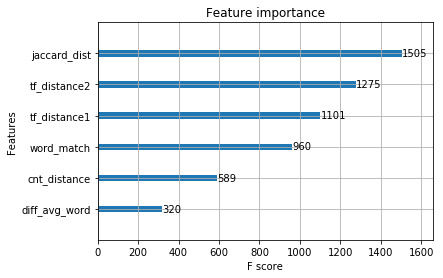

In [12]:
bst.save_model('input/bst_52.model')
xgb.plot_importance(bst)

## Submission

In [2]:
from utils import parallelize_dataframe
from utils import text_cleaning
from utils import word_match_share
from utils import preprocessing_test

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import paired_cosine_distances
from nltk.metrics.distance import jaccard_distance

In [14]:
test = pd.read_pickle("input/test.p")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345796 entries, 0 to 2345795
Data columns (total 2 columns):
question1    object
question2    object
dtypes: object(2)
memory usage: 53.7+ MB


In [3]:
df_test = pd.read_csv("input/test.csv", low_memory=False, iterator=True, chunksize=600000)
df_test = pd.concat(df_test, ignore_index=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [7]:
df_test['len_q1'] = df_test['question1'].apply(lambda x: len(str(x)))
df_test['len_q2'] = df_test['question2'].apply(lambda x: len(str(x)))
df_test['len_word_q1'] = df_test['question1'].apply(lambda x: len(str(x).split()))
df_test['len_word_q2'] = df_test['question2'].apply(lambda x: len(str(x).split()))
df_test['len_word_q2'] = df_test['len_word_q2'].fillna(0)
df_test['avg_world_len1'] = df_test['len_q1'] / df_test['len_word_q1']
df_test['avg_world_len2'] = df_test['len_q2'] / df_test['len_word_q2']

test['diff_avg_word'] = df_test['avg_world_len1'] - df_test['avg_world_len2']
test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)  

In [15]:
all_questions = test['question1'].append(test['question2'])
tfidf = TfidfVectorizer(lowercase=True, binary=True).fit(all_questions)
q1_tfidf1 = tfidf.transform(test['question1'])
q2_tfidf1 = tfidf.transform(test['question2'])
tfidf = TfidfVectorizer(lowercase=True, binary=True, ngram_range=(1,3), analyzer='word', \
                        max_features=100000, max_df=0.5, min_df=30, use_idf=True).fit(all_questions)
q1_tfidf2 = tfidf.transform(test['question1'])
q2_tfidf2 = tfidf.transform(test['question2'])

In [20]:
count = CountVectorizer(lowercase=True, binary=True, ngram_range=(1,10), analyzer='char', \
                        max_features=300000, max_df=0.999, min_df=50).fit(all_questions)
q1_count = count.transform(test['question1'])
q2_count = count.transform(test['question2'])

In [16]:
test['tf_distance1'] = paired_cosine_distances(q1_tfidf1, q2_tfidf1)
test['tf_distance2'] = paired_cosine_distances(q1_tfidf2, q2_tfidf2)

In [ ]:
test['cnt_distance'] = paired_cosine_distances(q1_count, q2_count)
test['jaccard_dist'] = df_test.apply(lambda x: jaccard_distance(set(str(x.question1).split(' ')), \
                                                                set(str(x.question2).split(' '))), axis=1)

In [20]:
d_test = xgb.DMatrix(df_test[training_fields])
p_test = bst.predict(d_test)

In [ ]:
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)